# Project description

### Summary

This project takes daily temperature data from Berlin Tempelhof for the years 1946 to July 2022 and forecasts based on this data the daily temperatre for the next three days. 


### Steps

1. Import packages
2. Get and clean data
3. Train-test split
4. Exploratory data analysis (descriptive statistics and plotting)
5. Baseline model that models trend and seasonality
6. Model time dependence of the remainder using an autoregressive (AR) model
7. Test the remainder for stationarity 
8. Plot ACF and PACF
9. AR and ARIMA models
10. Evaluate: AIC, cross-validation and evaluation on test data
11. Forecast for the next day - AR and ARIMA


# Imports

In [1]:
import os

import pandas as pd
import seaborn as sns
import numpy as np
import datetime

from pandas import Grouper
from pandas import read_csv
from pandas import DataFrame
from matplotlib import pyplot

import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly.graph_objects as go

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima import auto_arima

import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set the graph size
sns.set(rc={'figure.figsize':(12, 3)})


In [3]:
ls

README.md                   full_five
Untitled.ipynb              full_five.csv
arima_model.pkl             requirements.txt
arima_parameters.ipynb      temperature_forecast.ipynb
data/


# Read data

### Berlin temperature data

FILE FORMAT (MISSING VALUE CODE IS -9999):

* 01-06 SOUID: Source identifier
* 08-15 DATE : Date YYYYMMDD
* 17-21 TG   : mean temperature in 0.1 &#176;C
* 23-27 Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')

In [4]:
date = ['DATE']

In [5]:
df = pd.read_csv('data/ECA_blended_Berlin/TG_STAID002759.txt', sep=',', skiprows=18, skipinitialspace=True, parse_dates=date)
#, parse_dates=date

In [6]:
df.head(3)

,SOUID,DATE,TG,Q_TG
0,127488,1876-01-01,22,0
1,127488,1876-01-02,25,0
2,127488,1876-01-03,3,0


In [7]:
df.columns

Index(['SOUID', 'DATE', 'TG', 'Q_TG'], dtype='object')

In [8]:
df.dtypes

SOUID             int64
DATE     datetime64[ns]
TG                int64
Q_TG              int64
dtype: object

# Train-test split

In [9]:
def train_test(df):
    '''Split the last year of data into test data. Return test and train data'''
    df_train = df[:-365]
    df_test = df[-365:]
    return df_train, df_test

In [10]:
# Execute train test function and create test and train datasets
df, df_test = train_test(df)

#### Save in CSV

In [11]:
df_test.to_csv('data/temp_test.csv')

# Clean data and add features

### Cleaning functions

In [12]:
def clean_cols(df):
    '''
    Return dataframe with lower case column names
    '''
    df.columns = map(str.lower, df.columns)
    return df

In [13]:
def date_cols(df):
    ''' 
    Crate year, month, day and weekday columns.
    Return modified dataframe
    '''
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['weekday'] = df.index.weekday
    df['day'] = df.index.day
    return df

In [14]:
def date_to_index(df):
    '''
    Return dataframe with datetime column as the index
    '''
    df.set_index('date', inplace=True, drop=False)
    return df

In [15]:
def missing_to_nan(df):
    '''
    Replace missing values coded as -9999 with np.nan.
    Return dataframe
    '''
    df['tg'] = df['tg'].replace(-9999, np.nan)
    return df


### Call cleaning functions on Berlin temperature data

In [16]:
df = clean_cols(df)

In [17]:
df = date_to_index(df)

In [18]:
df = date_cols(df)

In [19]:
df = missing_to_nan(df)

In [20]:
df.index.year

Int64Index([1876, 1876, 1876, 1876, 1876, 1876, 1876, 1876, 1876, 1876,
            ...
            2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021],
           dtype='int64', name='date', length=53081)

### Create celsius 1 column

In [21]:
df['temp'] = df.tg/10

In [22]:
#Check fo missing values
df.isna().sum()

souid        0
date         0
tg         195
q_tg         0
year         0
month        0
weekday      0
day          0
temp       195
dtype: int64

### Missing values

In [23]:
# Creating yearly averages
g = df.groupby(pd.Grouper(freq='Y')).mean()

In [24]:
# Find value counts for variable indicating data quality (q_tg) - when 9, the value is missing 
df["q_tg"].value_counts()

0    52885
9      195
1        1
Name: q_tg, dtype: int64

In [25]:
# Find range of years with missing values
df['year'].loc[(df['q_tg']==9)].describe()[['min', 'max']]

min    1945.0
max    1945.0
Name: year, dtype: float64

# Exploratory data analysis

## Descriptive statistics

In [26]:
df.head(3)

,souid,date,tg,q_tg,year,month,weekday,day,temp
date,,,,,,,,,
1876-01-01,127488,1876-01-01,22.0,0,1876,1,5,1,2.2
1876-01-02,127488,1876-01-02,25.0,0,1876,1,6,2,2.5
1876-01-03,127488,1876-01-03,3.0,0,1876,1,0,3,0.3


In [27]:
df.dtypes

souid               int64
date       datetime64[ns]
tg                float64
q_tg                int64
year                int64
month               int64
weekday             int64
day                 int64
temp              float64
dtype: object

In [28]:
df.shape

(53081, 9)

In [29]:
df.tail(3)

,souid,date,tg,q_tg,year,month,weekday,day,temp
date,,,,,,,,,
2021-04-28,111448,2021-04-28,109.0,0,2021,4,2,28,10.9
2021-04-29,111448,2021-04-29,113.0,0,2021,4,3,29,11.3
2021-04-30,111448,2021-04-30,83.0,0,2021,4,4,30,8.3


In [30]:
df.describe()

,souid,tg,q_tg,year,month,weekday,day,temp
count,53081.000000,52886.000000,53081.000000,53081.000000,53081.000000,53081.000000,53081.000000,52886.000000
mean,119398.780581,93.769599,0.033082,1948.165935,6.513856,3.000000,15.729112,9.376960
std,8024.310022,78.771228,0.544513,41.953926,3.450539,2.000019,8.799924,7.877123
min,111448.000000,-226.000000,0.000000,1876.000000,1.000000,0.000000,1.000000,-22.600000
25%,111448.000000,33.000000,0.000000,1912.000000,4.000000,1.000000,8.000000,3.300000
50%,111448.000000,94.000000,0.000000,1948.000000,7.000000,3.000000,16.000000,9.400000
75%,127488.000000,157.000000,0.000000,1984.000000,10.000000,5.000000,23.000000,15.700000
max,128124.000000,305.000000,9.000000,2021.000000,12.000000,6.000000,31.000000,30.500000


In [31]:
#Accessing data for specific date
df.loc['2017-10-30']

souid                   111448
date       2017-10-30 00:00:00
tg                        61.0
q_tg                         0
year                      2017
month                       10
weekday                      0
day                         30
temp                       6.1
Name: 2017-10-30 00:00:00, dtype: object

In [32]:
# Descriptive statistics for February 1900
df.loc['1900-02'].describe()

,souid,tg,q_tg,year,month,weekday,day,temp
count,28.0,28.000000,28.0,28.0,28.0,28.0000,28.000000,28.000000
mean,127488.0,13.107143,0.0,1900.0,2.0,3.0000,14.500000,1.310714
std,0.0,40.632353,0.0,0.0,0.0,2.0367,8.225975,4.063235
min,127488.0,-46.000000,0.0,1900.0,2.0,0.0000,1.000000,-4.600000
25%,127488.0,-21.250000,0.0,1900.0,2.0,1.0000,7.750000,-2.125000
50%,127488.0,1.500000,0.0,1900.0,2.0,3.0000,14.500000,0.150000
75%,127488.0,44.500000,0.0,1900.0,2.0,5.0000,21.250000,4.450000
max,127488.0,101.000000,0.0,1900.0,2.0,6.0000,28.000000,10.100000


In [33]:
# Drop all missing values
df.dropna(inplace=True)

In [34]:
#Create yearly mean temperature column 
yearly_temp = df.resample("1y")[['temp']].mean()

### Create three datasets   - pre-WW2, post-WW2, and 2017-2022

This is done as the data for year 1945 is missing completely.
For forecasting only the post WW2 data will be used as the model does not accept missing values. 
For plotting the entire dataset will be used.

1. 1876 - 1944
2. 1946 - 2022
3. 2017 - 2022 (for forecasting the next day's temperature, only a few years are needed)

In [35]:
df_post = df.loc[(df.year>1945)]
df_pre = df.loc[(df.year < 1945)]
df_five = df.loc['2017-5-1':]

# df_five = df.loc[(df.year > 2016)]

## Plotting

In [36]:
df.isna().sum()

souid      0
date       0
tg         0
q_tg       0
year       0
month      0
weekday    0
day        0
temp       0
dtype: int64

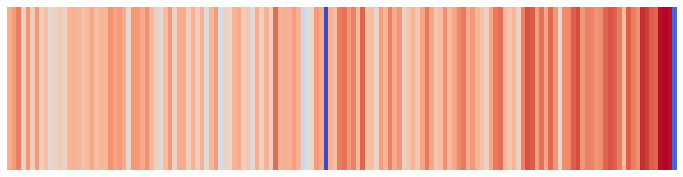

In [37]:
# Plot a heatmap of the mean yearly temperatures from 1876 to 2021
# the redder the stripes the warmer the yearly mean temperature. 
# The dark blue stripe in the middle is the missing 1945 year.

plt.figure(figsize=(12, 3))
sns.heatmap(yearly_temp.T, cmap='coolwarm', 
            xticklabels=[], yticklabels=[], # switch off all labels
            cbar=False
           )
_ = plt.xlabel(None)

In [38]:
# Set the graph size
sns.set(rc={'figure.figsize':(12, 3)})

In [39]:
# Plot temperature 
def simple_plot(df):
    '''Plot temperature in celsius.'''
    df['temp'].plot(linewidth=0.5)

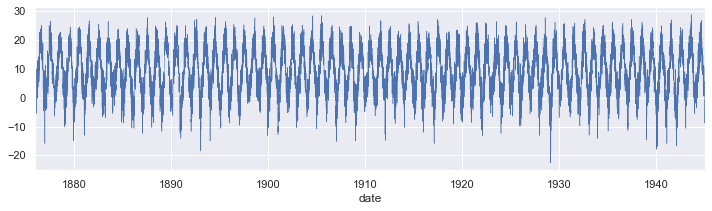

In [40]:
# Plot pre WW2 temperature
plt.figure(figsize=(12, 3))
simple_plot(df_pre)

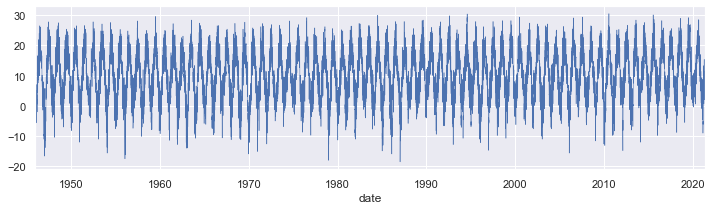

In [41]:
# Plot post- WW2 temperature
simple_plot(df_post)

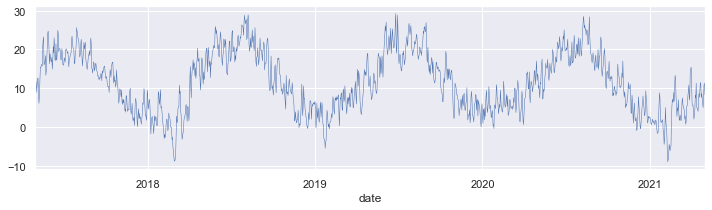

In [42]:
simple_plot(df_five)

### 30-day moving average 

<AxesSubplot:xlabel='date'>

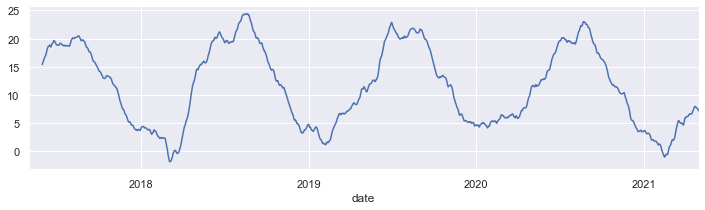

In [43]:
# Moving average of 30 days
df_five['temp'].rolling(window=30).mean().plot()

<AxesSubplot:xlabel='date'>

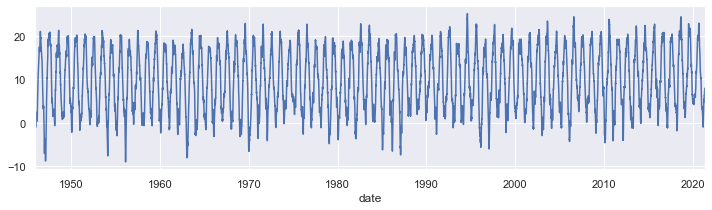

In [44]:
df_post['temp'].rolling(window=30).mean().plot()

### One year moving average

<AxesSubplot:xlabel='date'>

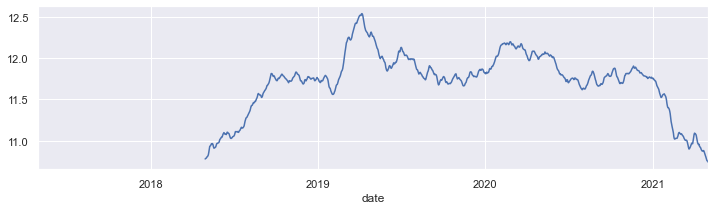

In [45]:
df_five['temp'].rolling(window=365).mean().plot()

<AxesSubplot:xlabel='date'>

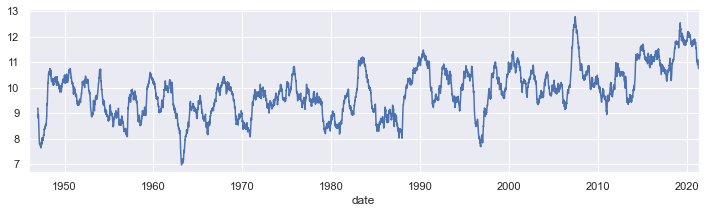

In [46]:
df_post['temp'].rolling(window=365).mean().plot()

### 10-year moving average 1945- 2021

<AxesSubplot:xlabel='date'>

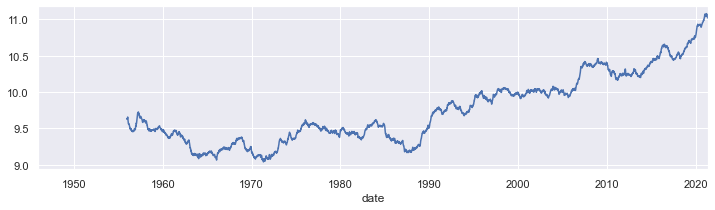

In [47]:
df_post['temp'].rolling(window=3650).mean().plot()

In [48]:
df

,souid,date,tg,q_tg,year,month,weekday,day,temp
date,,,,,,,,,
1876-01-01,127488,1876-01-01,22.0,0,1876,1,5,1,2.2
1876-01-02,127488,1876-01-02,25.0,0,1876,1,6,2,2.5
1876-01-03,127488,1876-01-03,3.0,0,1876,1,0,3,0.3
1876-01-04,127488,1876-01-04,-58.0,0,1876,1,1,4,-5.8
1876-01-05,127488,1876-01-05,-98.0,0,1876,1,2,5,-9.8
...,...,...,...,...,...,...,...,...,...
2021-04-26,111448,2021-04-26,50.0,0,2021,4,0,26,5.0
2021-04-27,111448,2021-04-27,72.0,0,2021,4,1,27,7.2
2021-04-28,111448,2021-04-28,109.0,0,2021,4,2,28,10.9


### Monthly average temperature

(0.0, 25.0)

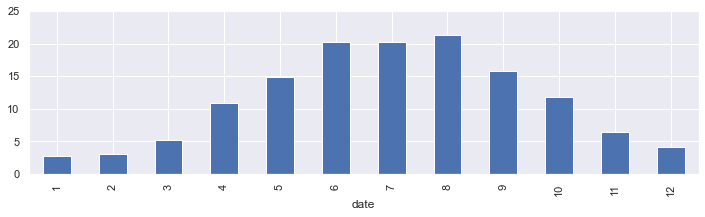

In [49]:
# 2017-2021
months = df_five.index.month
df_five.groupby(months)['temp'].mean().plot(kind='bar')
plt.ylim([0, 25])

(0.0, 25.0)

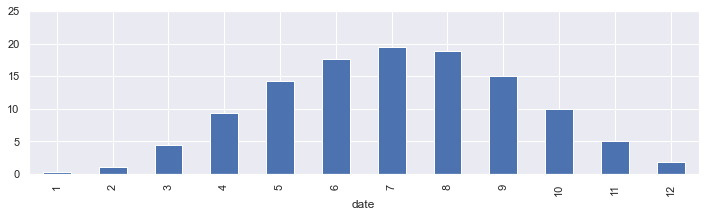

In [50]:
# 1946-2021
months = df_post.index.month
df_post.groupby(months)['temp'].mean().plot(kind='bar')
plt.ylim([0, 25])

### Plot specific years, months, days

In [51]:
def plot_year(df, year=2000):
    '''Plot a specific year, default is 2000.'''
    fig, ax = plt.subplots(figsize=(12, 4))
    x = np.arange(1, 364)
    y = df['temp'].loc[(df.year == year)]
    ax.plot(y)
    plt.ylim([-10, 30])
    # df['temp'].loc[(df.year == year)].plot(linewidth=0.5)


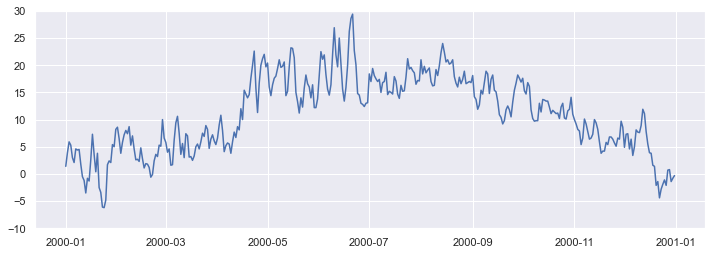

In [52]:
plot_year(df_post, 2000)

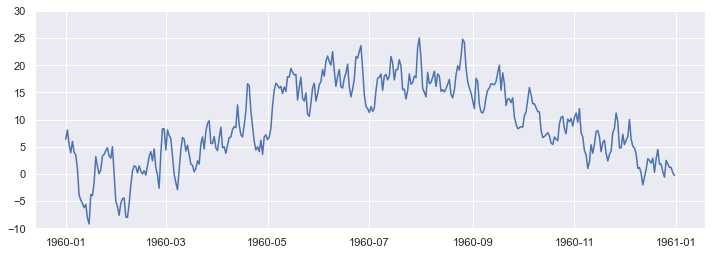

In [53]:
plot_year(df_post, 1960)

In [54]:
def plot_month_year(df = df_post, month=1, year= 2000):
    '''
    Plot a specific month.
    '''
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(1, 30)
    y = df['temp'].loc[(df.month == month) & (df.year == year)]
    ax.plot(y) 
            #title=f'Temperature in {month}th month in {year} in Berlin Tempelhof (1946-2022)')
    plt.title(f'Temperature in {month}th month in {year} in Berlin Tempelhof (1946-2022)')
    if (month > 5) & (month <=9):
        plt.ylim([8, 30]) # define y-axis (temperature) limits for summer months
    elif (month > 10) | (month <4):
        plt.ylim([-12, 20]) # define y-axis (temperature) limits for winter months
    else:
        plt.ylim([0, 20]) # define y-axis (temperature) limits for remaining months



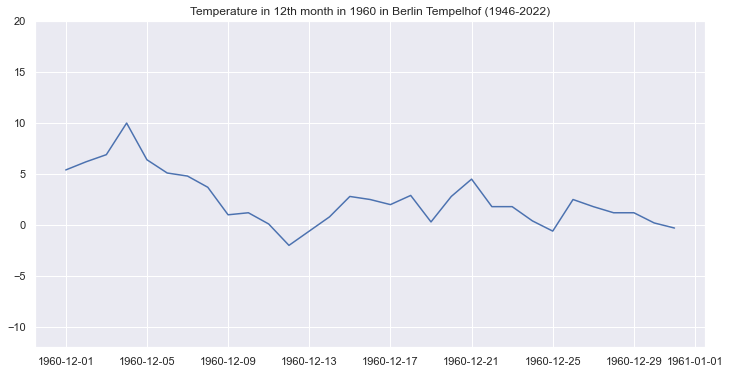

In [55]:
plot_month_year(df_post, 12, 1960)

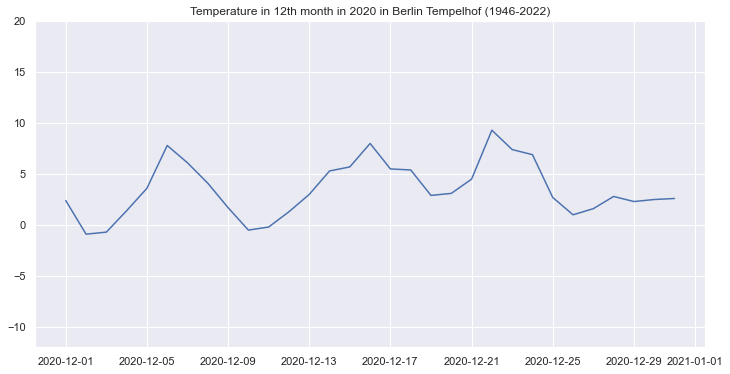

In [56]:
plot_month_year(df_post, 12, 2020)

In [57]:
# Read in data for plotting
series = pd.read_csv('data/ECA_blended_Berlin/TG_STAID002759.txt', sep=',', index_col=0, skiprows=18, skipinitialspace=True, parse_dates=['DATE'], squeeze=True)
series['DATE'] = pd.to_datetime(series['DATE'])
series = series.set_index('DATE', drop=False) 



In [58]:
# Drop February 29th days (leap years interfere with plotting stacked years due to shape of year)
series = series.loc[~(series['DATE'].dt.month.eq(2) & series['DATE'].dt.day.eq(29))] 

In [59]:
# Drop unnecessary columns
series = series.drop(['Q_TG', 'DATE'], axis= 1)

In [60]:
series['TG'] = series['TG']/10 

In [61]:
def stacked_yearly_plots(df = series, year_lowlim = 2010, year_uplim = 2020):
    '''
    Plot the entire year for selected years in a stacked line plot
    '''
    groups = series.groupby(Grouper(freq='A'))
    years = DataFrame() # empty dataframe
    
    for date, tempcol in groups:
        if (date.year >= year_lowlim) & (date.year <= year_uplim):
            years[date.year] = [i[0] for i in tempcol.values] # Generate a dataframe with years as columns,
            # the days of the year as index, and temperature as values 
    years.plot(subplots=True, legend=True)
    #pyplot.show()

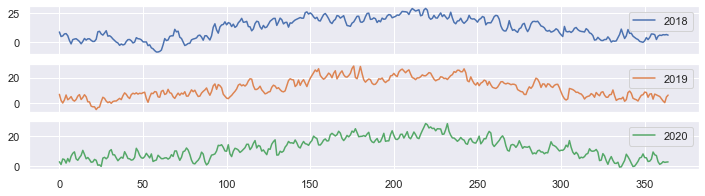

In [62]:
stacked_yearly_plots(df = series, year_lowlim = 2018, year_uplim = 2020)

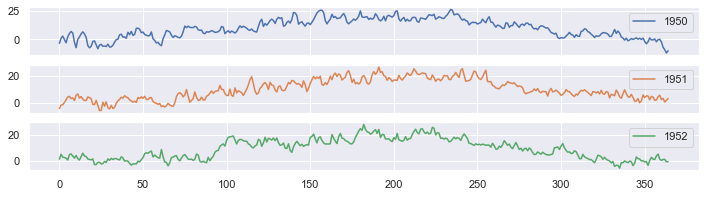

In [63]:
stacked_yearly_plots(df = series, year_lowlim = 1950, year_uplim = 1952)

### Average yearly temperature

<AxesSubplot:title={'center':'Average yearly temperature in Berlin Mitte (1876-2020)'}, xlabel='date'>

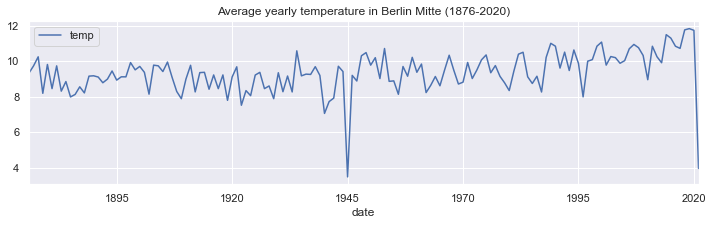

In [64]:
# Plot the yearly average temperature
yearly_temp = df.resample("1y")[['temp']].mean()
yearly_temp.plot(title='Average yearly temperature in Berlin Mitte (1876-2020)')

In [65]:
# Plot average monthly temperature

def monthly_mean_temp(df = df_post, month_chosen = 1):
    '''Plot average temperature of month_chosen'''
    monthly_temp = df.resample("1m")[['temp']].mean() # get the mean monthly temperature
    monthly_temp['date'] = monthly_temp.index
    month_temp = monthly_temp.loc[(monthly_temp.date.dt.month.eq(month_chosen))] # keep only chosen months
    month_temp.drop(['date'], axis=1, inplace=True)
    month_temp.plot(title=f'Average {month_chosen}th month temperature in Berlin Tempelhof (1946-2022)')
    

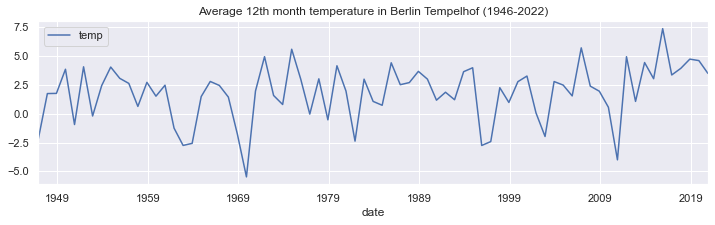

In [66]:
monthly_mean_temp(month_chosen = 12)

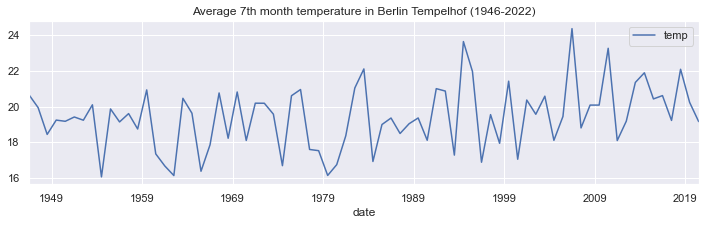

In [67]:
monthly_mean_temp(month_chosen = 7)

### Mean monthly temperature

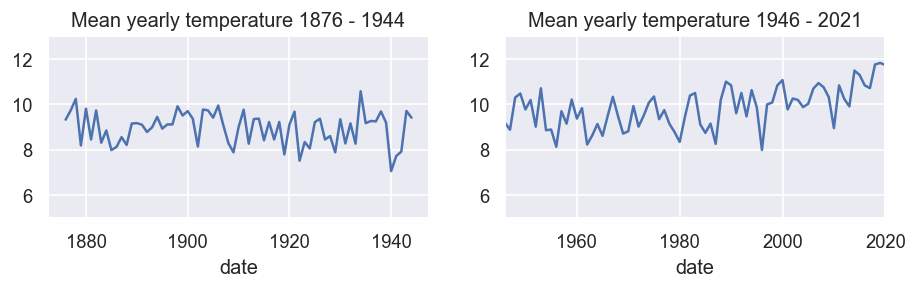

In [68]:
plt.rcParams.update({'figure.figsize':(9,2), 'figure.dpi':120})

fig, ax = plt.subplots(1,2)
figsize = [6, 12]
ax[0].set_ylim(5,13)
ax[1].set_ylim(5,13)
ax[1].set_xlim(1946,2020)
df_pre.groupby(df_pre.index.year)['temp'].mean().plot(title= 'Mean yearly temperature 1876 - 1944', ax = ax[0])
df_post.groupby(df_post.index.year)['temp'].mean().plot(title= 'Mean yearly temperature 1946 - 2021', ax = ax[1])
plt.show()

# Time series decomposition 


Time series decomposition =  a mathematical procedure which transforms a time series into multiple different time series. The original time series is often split into 3 component series:

1. Seasonal: Patterns that repeat within a fixed period of time. E.g. the four seasons of a year. 

2. Trend: The underlying trend of the metrics. E.g. mean temperatures increasing over the past decades. 

3. Remainder: Also called noise, error or residual. This is the residual of the original time series after the seasonal & trend series are subtracted from it. 
    
    * We will need the remainder to decide how many lags to include in the AR model (instead of looking at the temperature variable) as using the remainder we remove the effects of trend and seasonality and can observe the pure effect of time dependence.


In [69]:
# With statsmodels seasonal_decompose (returns the trend, seasonality and remainder component)
result = seasonal_decompose(df_five['temp'], model='additive', period=365, extrapolate_trend='freq')


Text(0.5, 0.98, 'Additive decomposition of 2017-2021 series')

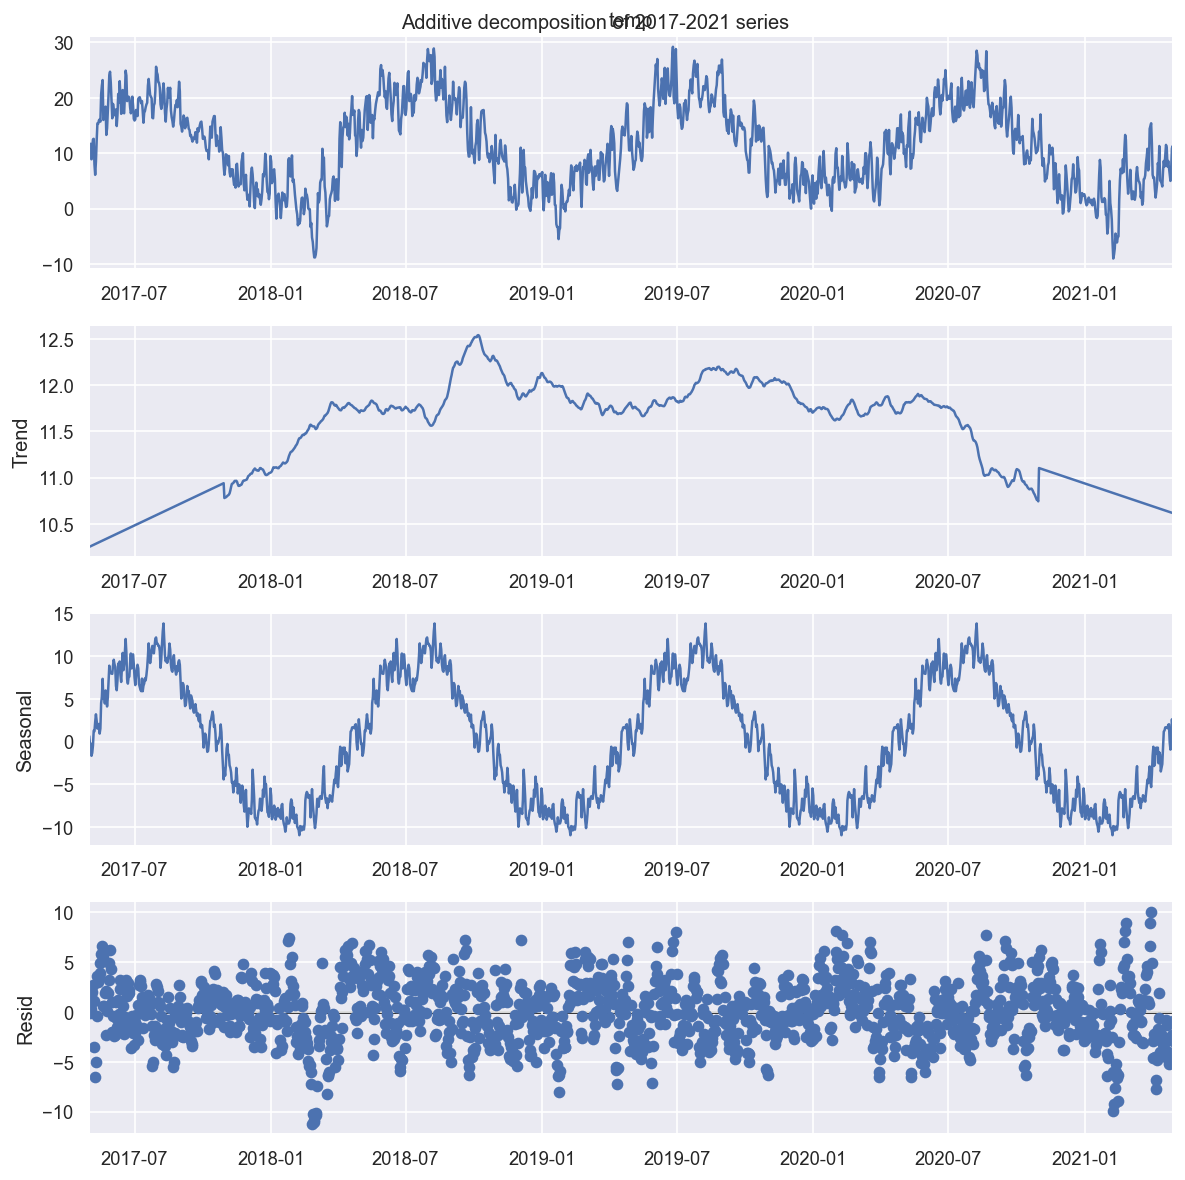

In [70]:
plt.rcParams.update({'figure.figsize': (10,10)})
result.plot().suptitle('Additive decomposition of 2017-2021 series', fontsize=12)

## Baseline model to model trend and seasonality

In [71]:
# Get timestep - this is just a number running from 0 to the n of observations in dataframe
df_post['timestep'] = list(range(len(df_post)))
df_five['timestep'] = list(range(len(df_five)))


In [72]:
def X_and_y(df):
    '''
    Define X and Y to be used to predict the linear trend
    '''
    X = df[['timestep']]
    y = df['temp']
    return X, y

### Model trend of temperature over time - manual without statsmodels assuming linear dependence

In [73]:
# Model the (upwards or downward) trend of the temperature over time 
#- we assume the trend to be liner based on visual inspection above 
plt.rcParams.update({'figure.figsize':(11,3)})

def pred_trend(df, plot=True):
    '''
    Predict and plot the time-trend (time-dependence) of the temperature: linear regression on timestemp
    '''
    X, y = X_and_y(df)
    m = LinearRegression()
    m.fit(X, y)
    df['trend'] = m.predict(X)
    print(f'The slope of the trend: {m.coef_}')
    if plot:
        df[['temp', 'trend']].plot()
        
    return df

The slope of the trend: [5.86853663e-05]


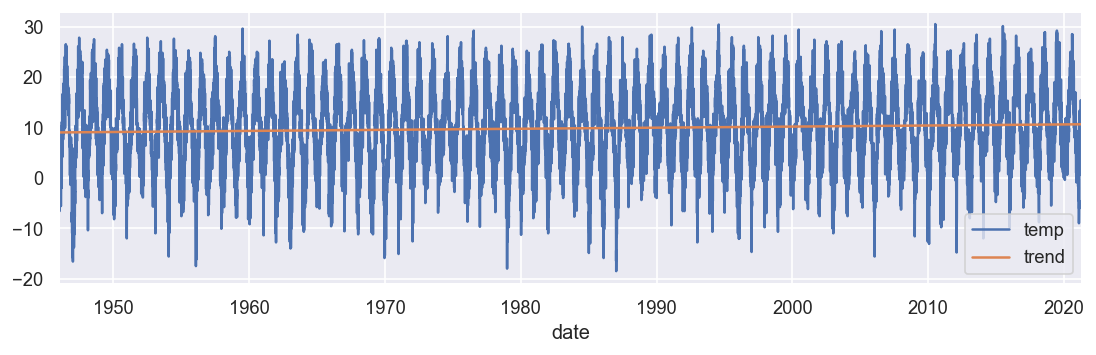

In [74]:
df_post=pred_trend(df_post)

The slope of the trend: [-0.00315766]


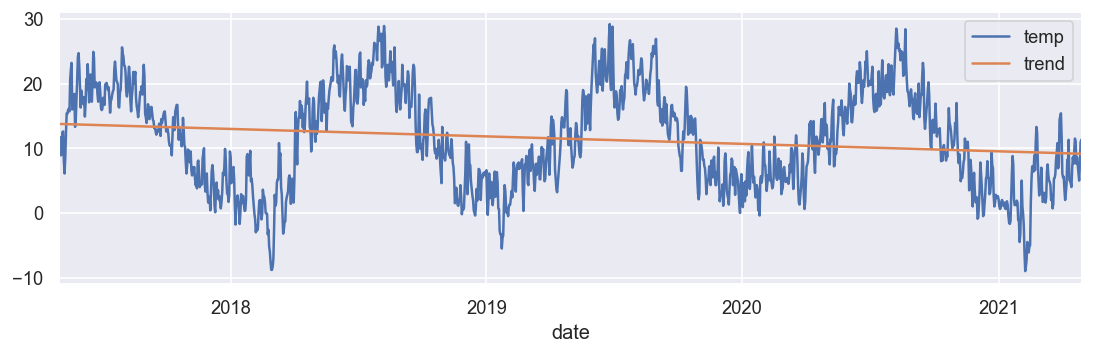

In [75]:
df_five=pred_trend(df_five)

<AxesSubplot:title={'center':'Trend of mean temperature, 2017-2021'}, xlabel='date'>

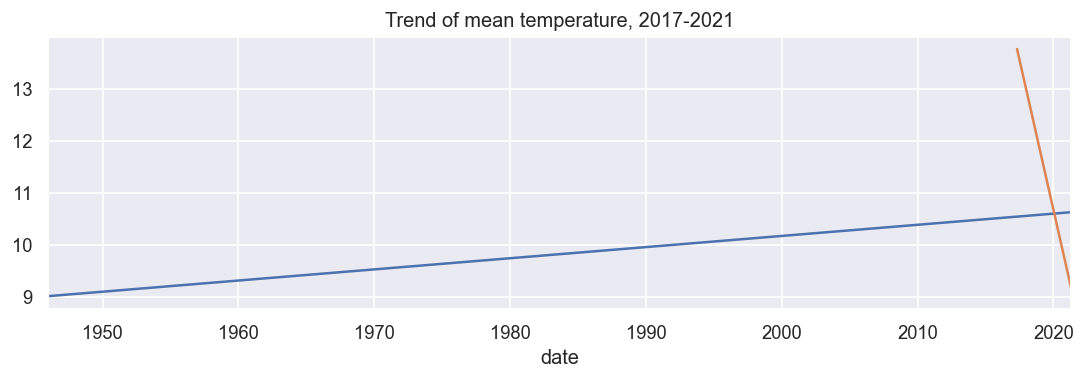

In [76]:
plt.rcParams.update({'figure.figsize':(11,3), 'figure.dpi':120})
df_post['trend'].plot(title = 'Trend of mean temperature, 1946-2021')
df_five['trend'].plot(title = 'Trend of mean temperature, 2017-2021')

#### Conclusion based on seasonal_decompose and linear modelling of trend: 

* Long-term rising trend in  mean temperature
* past 5 years experienced a more parabolic-looking pattern with increasing trend of mean temperature around 2018 and thereafter a decreasing trend

### Model the seasonality of temperature

1. Create seasonal dummies for each month 
2. Set X = seasonal dummies and timestep, Y = temperature
3. Linear regression 

In [77]:
def seasonal_dum(df):
    '''
    Get monthly seasonal dummies and join them to the dataframe. 
    Return dataframe.
    '''
    seasonal_dummies = pd.get_dummies(df.index.month, drop_first=True, prefix='month').set_index(df.index)
    df = df.join(seasonal_dummies)
    return df

In [78]:
def get_X_months(df):
    '''
    Place monthly dummies and the timestep as the independent variable
    '''
    X = df[df.columns[df.columns.isin(['timestep', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12'])]]
    return X

In [79]:
def model_seasonality(df, plot=False):
    '''
    Predict and plot the seasonal trend of temperature using linear regression, 
    with seasonal dummies and the timestep as independent variables. 
    Return dataframe.
    '''
    length = len(df)
    X_old, y = X_and_y(df)
    X = get_X_months(df)
    y_new = y[-length:]
    m = LinearRegression()
    m.fit(X, y_new)
    df['trend_seasonal'] = m.predict(X)
    if plot==True:
        fig,ax =  plt.subplots() 
        ax.set_ylim(-20,35)
        df[['temp', 'trend_seasonal']].plot(title = 'Temperature and seasonal trend', ax = ax)
        plt.show()
    return df


In [80]:
df_post = seasonal_dum(df_post)
df_five = seasonal_dum(df_five)

In [81]:
X = get_X_months(df_post)
X_five = get_X_months(df_five)

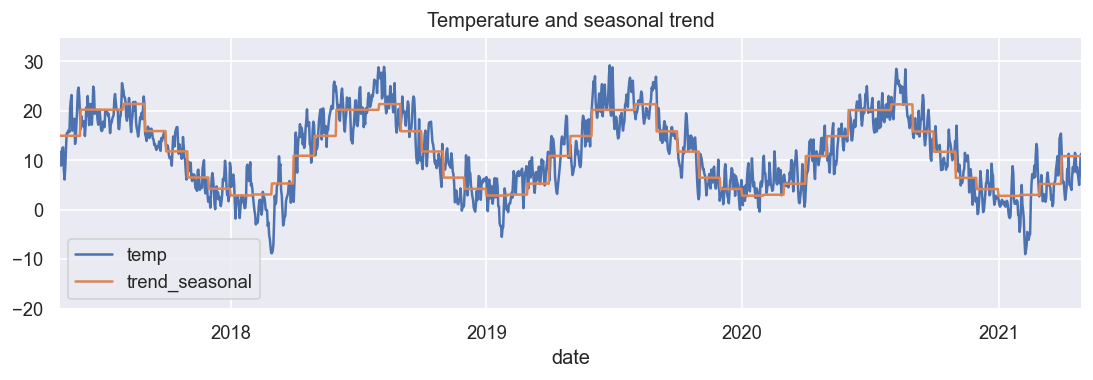

In [82]:
df_five = model_seasonality(df_five, plot=True)

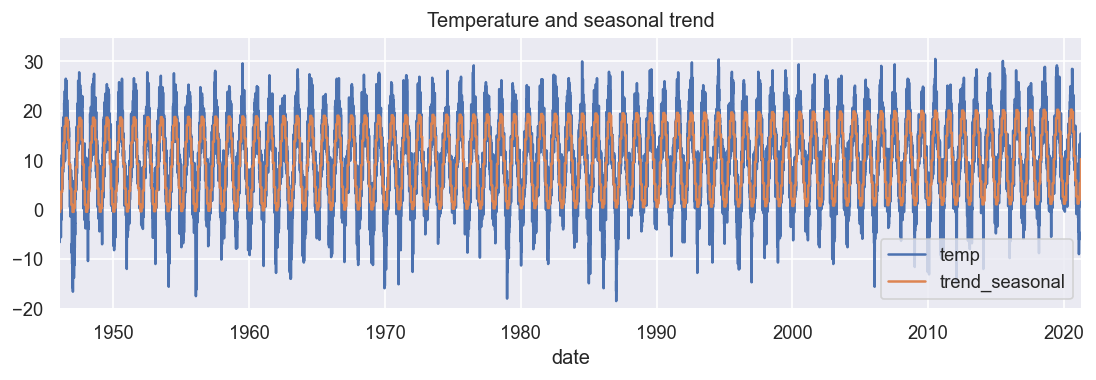

In [83]:
df_post = model_seasonality(df_post, plot=True)

### Extract and plot remainder

In [84]:

def get_remainder(df, plot=False):
    '''
    Extract remainder by subtracting the seasonal trend from temperature. Plot remainder
    '''
    df['remainder'] = df['temp'] - df['trend_seasonal']
    if plot==True:
        fig,ax =  plt.subplots() 
        ax.set_ylim(-25,20)
        df['remainder'].plot(title = f'Remainder for years {min(df.year)} - {max(df.year)}', ax = ax)
        plt.show()
    return df


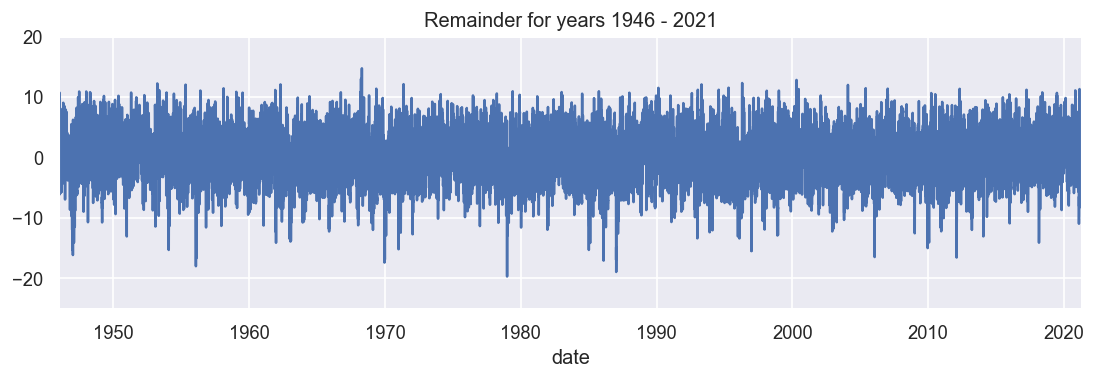

In [85]:
df_post = get_remainder(df_post, plot=True)

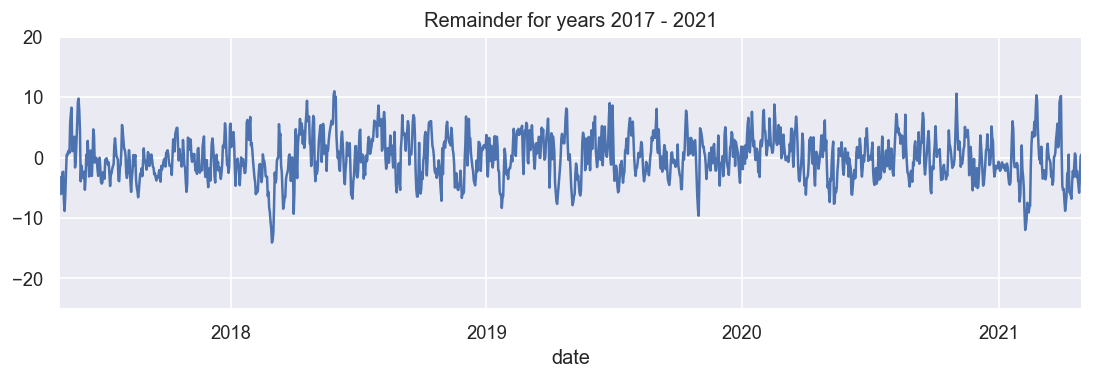

In [86]:
df_five = get_remainder(df_five, plot=True)

### Save remainder in csv

In [87]:
df_post['remainder'].to_csv('data/post_remainder.csv')
df_five['remainder'].to_csv('data/five_remainder.csv')

# Check for stationarity - Augmented   Dickey-Fuller test


**What is stationarity:**

- = the statistical properties of the series do not depend on the time at which the series is observed.

**Basic conditions of stationarity:**

- constant mean
- constant standard deviation
- no seasonality

**Why is stationarity important:**

- For most time-series forecasting models (ARIMA, AR) to work, the data must be stationary.

**How to detect stationarity:**
- visually
- global vs local tests
- augmented-Dicky-Fuller test

**What is the ADF and what does it detect:**

- ADF is a unit root test: null hypothesis is that there is a unit root, ie. the time series is not stationary. To reject the null hypothesis, we need the p < 0.05.
- The ADF detects non-stationarity in the long-term cycle = the trend of the series.
- ADF does not detect seasonality (periodic behaviour/pattern that is predictable, e.g. monthly)


**How to transform a non-stationary time-series into stationary:** 
- taking first (or higher order) differences to stabilize the mean (=computing the difference between consecutive observations)
- transformations (e.g. log) can help to stabilize the variance
- removing seasonality

Some sources: 

* Great intuitive explanation for unit root: https://stats.stackexchange.com/questions/29121/intuitive-explanation-of-unit-root
* on stationarity and differencing: https://otexts.com/fpp2/stationarity.html
* Definition of stationarity: Probability, Random variables and stochastic processes 4th edition, Papoulis and Pillai


In [88]:
# Unit root test

def check_stationarity(df):
    '''
    Print out the main results of the Augmented Dicky Fuller test in a nice format.
    '''
    result = adfuller(df)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items(): # pvalues are a dict that is the fourth indexed item
        print('\t%s: %.3f' % (key, value)) # prints p-values with 3 digit accuracy

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m") # prints stationary in green
    else:
        print("\x1b[31mNon-stationary\x1b[0m") # prints non-stationary in red

# Source: https://machinelearningmastery.com/time-series-data-stationary-python/


In [89]:
check_stationarity(df_post['temp'])

ADF Statistic: -12.932323
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


In [90]:
check_stationarity(df_post['remainder'])

ADF Statistic: -23.392011
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


In [91]:
check_stationarity(df_five['temp'])

ADF Statistic: -2.299956
p-value: 0.171982
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Non-stationary


In [92]:
check_stationarity(df_five['remainder'])

ADF Statistic: -13.004366
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Stationary


### Save pre and post 1945 data

In [93]:
df_post.to_csv('data/df_post.csv', index_label =False)
df_five.to_csv('data/df_five.csv', index_label =False)

In [94]:
def read_csv(name):
    '''
    Read the CSV to pandas and make the index a datatime.
    '''
    df = pd.read_csv(f'data/{name}.csv')
    df.index = pd.to_datetime(df.index)
    print(df.index.dtype)
    return df
    

In [95]:
df_post = read_csv('df_post')
df_five = read_csv('df_five')

datetime64[ns]
datetime64[ns]


# Time-series forecasting models

We can model time-series in three ways: 

**1. Autoregressive (AR) model**

$$ y_t = w_0 + w_1 y_{t-1} + w_2 y_{t-2} + .. + w_n y_{t-n} $$

* In the autoregressive model, output variable depends linearly on its own previous values. 

**2. Moving average (MA) model**

$$ y_t = \epsilon_t + \beta_1 \epsilon_{t-1} + \beta_2 \epsilon_{t-2} +  .. + \beta_n \epsilon_{t-n} $$

* the current value is a result of unexpected events. This model uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. 

**3. Autoregressive moving average (ARMA) model**

$$ y_t = w_1 y_{t-1} + w_2 y_{t-2} + .. + w_n y_{t-n} + \epsilon_t + \beta_1 \epsilon_{t-1} + \beta_2 \epsilon_{t-2} +  .. + \beta_n \epsilon_{t-n} $$

* Combination of two models above 


* +the ARIMA - the autoregressive *Integrated* moving average model


# Forecast with an autoregressive (AR) model

The first-order autoregression, AR(1):
$$ y_t = w_0 + w_1 y_{t-1} + \epsilon $$

* value at time t depends *only* on the value at time t-1

The second-order autoregression, AR(2):
$$ y_t = w_0 + w_1 y_{t-1} + w_2 y_{t-2} + \epsilon $$

* value at time t depends on value at time t-1 and t-2


**AR model assumptions**
1. residuals are independent and identically distributed (IID) (i.e. no autocorrelation, homoscedasticity, expectation is zero, same distribution)


2. weak stationarity

    * Strict stationarity: Your time series is completely time invariant.
    * Weak stationarity: The mean and variance do not change over time but auto-covariance depends on the time distance n between the steps t-n and t, rather than their absolute positions, so it can still be modelled as the same distribution.
    
    

3. weak dependence = “A stationary time series process […] is said to be weakly dependent if xt and xt−h are “almost independent” as h” goes to infinity. “In other words, as the variables get farther apart in time, the correlation between them becomes smaller and smaller.”)


## Choosing the number of lags in the AR model

### 1.  Auto-correlation function (ACF) and Partial autocorrelation function (PACF)


Plotting the ACF gives us an idea of how many lags of the variable of interest we want to include in the AR model.

**ACF:**

* The correlation between the observation at the current time spot and the observations at previous time spots.

$$ Corr(y_t, y_t-h) = \frac{Cov(y_t, y_t-h)}{sqrt(V(y_t) * V(y_t-h)} $$


**PACF:**

* The correlation between observations at two time spots given that we consider both observations are correlated to observations at other time spots, i.e. correlation between y_t and y_t-h, conditional on the intermediate values

$$ \delta_t = Corr(y_t, y_t-h | y_t-1, ... , y_t-h+1 $$



#### When to use autoregressive (AR), Moving average (MA) or an Autoregressive integrated moving average (ARIMA) model based on ACF and PACF: 

**AR process**: the ACF plot will gradually decrease and simultaneously the PACF should have a sharp drop after p significant lags. 

**MA process**: the ACF should show a sharp drop after a certain q number of lags while PACF should show a geometric or gradual decreasing trend. 

**ARIMA:** if both ACF and PACF plots demonstrate a gradual decreasing pattern.

Source: https://towardsdatascience.com/identifying-ar-and-ma-terms-using-acf-and-pacf-plots-in-time-series-forecasting-ccb9fd073db8

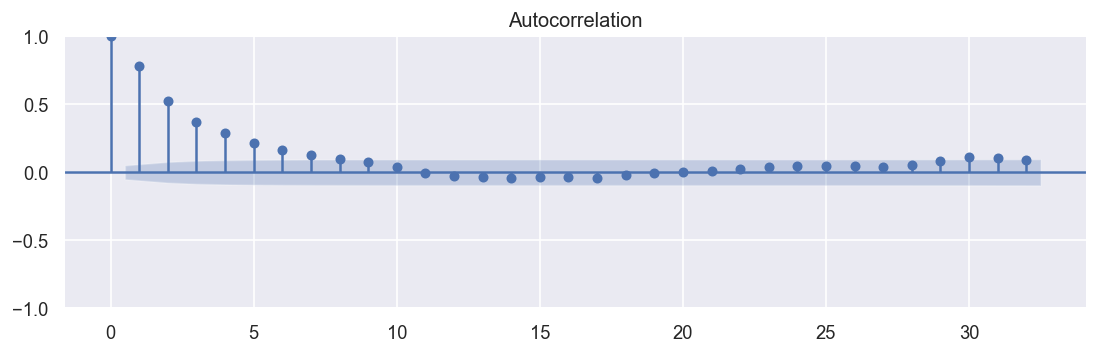

In [96]:
# ACF
plt.rcParams.update({'figure.figsize':(11,3), 'figure.dpi':120})
plot_acf(df_five['remainder']);

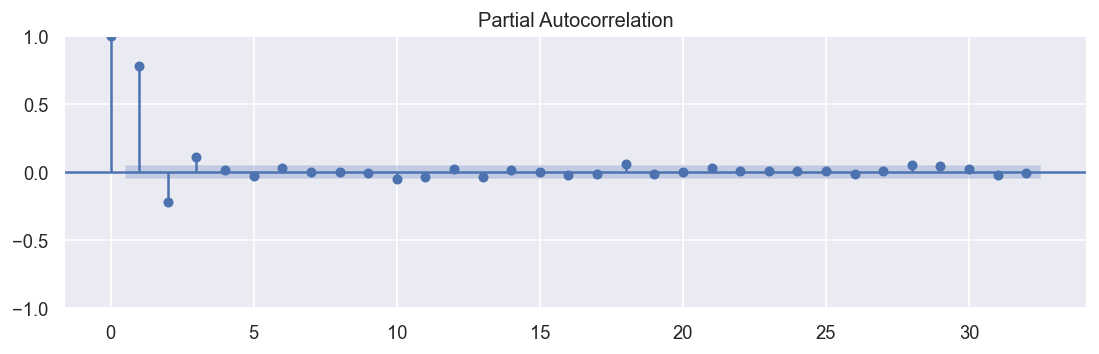

In [97]:
plot_pacf(df_five['remainder']);

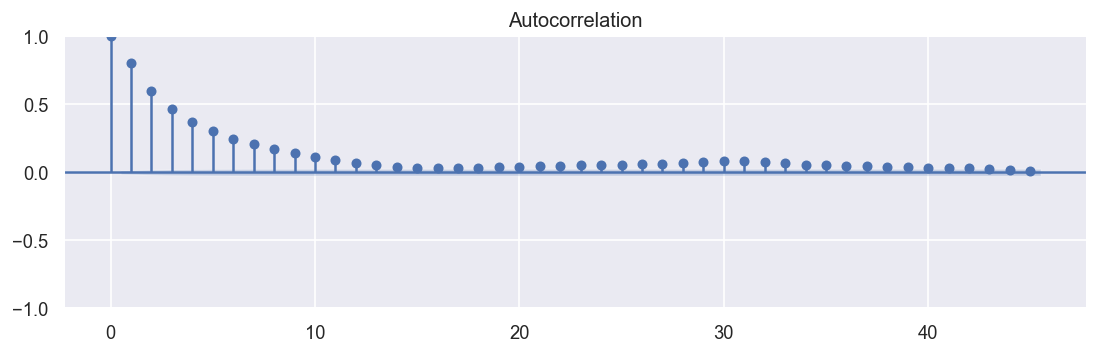

In [98]:
plot_acf(df_post['remainder']);

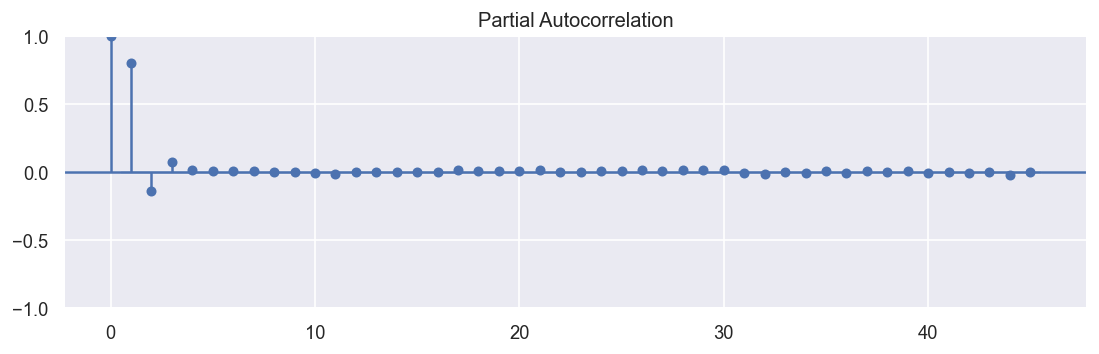

In [99]:
plot_pacf(df_post['remainder']);

#### Conclusion of ACF and PACF

- The ACF shows a slow decay
- The PACF shows temperature today dependent on (stongest dependence on: t-1, t-2, t-3, small dependence: t-10, t-18)


### 2. Bayesian information criteria (BIC)

**Select number of lags to use in the AR model based on BIC**

BIC = A method to determine statistically how many of the lags we want to use in predicting the error of our model. 

It helps us to decide the balance between how well our model is performing (i.e. fitting the data, using log-likelihood = mean squared error in case of regression) vs how complex it is - the BIC penalizes more complex models for the benefit of generalisability. 

The lower the score, the less information is lost. 

In [100]:
lag_order_post = ar_select_order(df_post['remainder'], maxlag=12)
lag_order_five = ar_select_order(df_five['remainder'], maxlag=12)

In [101]:
# print out BIC 'score' for each lag order, we will want to choose the lag order that minimises BIC
lag_order_post.bic

{(1, 2, 3): 124227.68336906124,
 (1, 2, 3, 4): 124227.77549824331,
 (1, 2, 3, 4, 5): 124236.57956915937,
 (1, 2, 3, 4, 5, 6): 124245.0821515929,
 (1, 2, 3, 4, 5, 6, 7): 124253.90906643751,
 (1, 2, 3, 4, 5, 6, 7, 8): 124263.50437954898,
 (1, 2, 3, 4, 5, 6, 7, 8, 9): 124273.6735120088,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10): 124283.21020709306,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11): 124288.37198194566,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12): 124298.31542033715,
 (1, 2): 124370.20276972697,
 (1,): 124887.48343627741,
 0: 153613.49683190338}

In [102]:
lag_order_post.ar_lags

[1, 2, 3]

In [103]:
lag_order_five.ar_lags

[1, 2, 3]

### Conclusion: 

* Both the PACF and the BIC suggest the last three values of temperature's remainder to be the most predictive of today's temperature.  

## Autoregressive (3) model

#### Predict remainder using 3 lags

In [104]:
def create_lags(df, lags=3):
    '''
    Extract user-defined number of lags from the remainder.
    Return dataframe with lags.
    '''
    number_lags = lags
    for lag in range(1, number_lags + 1):
        df[f'lag{str(lag)}'] = df['remainder'].shift(lag)
    return df

In [105]:
def X_full_y_full(df):
    '''
    Return the X (dataframe) and y (pandas series) for the full model.
    '''

    X_full = df.drop(['tg', 'temp', 'q_tg', 'month', 'weekday', 'year', 'day', 'date', 'souid', 'trend_seasonal', 'remainder', 'trend', 'predicted_remainder'], axis=1)
    y_full = df['temp']
    return X_full, y_full

In [106]:
def ar_remainder(df,lag_no, plot=True, summary=True):
    '''
    Predict the remainder with an AR(n=lag_no) model.
    Optional: print summary of AR model and 
    plot the true and predicted remainder.
    '''
    ar_model = AutoReg(endog=df['remainder'], lags=lag_no).fit()
    df['predicted_remainder']= ar_model.predict()
    if summary:
        print(ar_model.summary())
    if plot:
        df[['remainder', 'predicted_remainder']].plot()
        plt.title(f'AR({lag_no}) model predicted remainder')


                            AutoReg Model Results                             
Dep. Variable:              remainder   No. Observations:                 1461
Model:                     AutoReg(3)   Log Likelihood               -3209.951
Method:               Conditional MLE   S.D. of innovations              2.187
Date:                Thu, 29 Sep 2022   AIC                           6429.902
Time:                        16:37:15   BIC                           6456.326
Sample:                    05-04-2017   HQIC                          6439.760
                         - 04-30-2021                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0019      0.057      0.032      0.974      -0.110       0.114
remainder.L1     0.9728      0.026     37.355      0.000       0.922       1.024
remainder.L2    -0.3206      0.035     -9.04

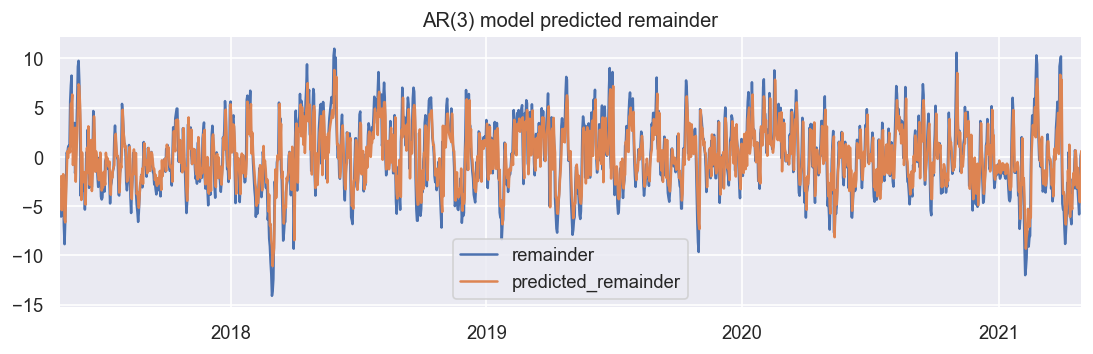

In [107]:
ar_remainder(df=df_five, lag_no= 3)

                            AutoReg Model Results                             
Dep. Variable:              remainder   No. Observations:                27514
Model:                     AutoReg(3)   Log Likelihood              -62115.875
Method:               Conditional MLE   S.D. of innovations              2.314
Date:                Thu, 29 Sep 2022   AIC                         124241.749
Time:                        16:37:16   BIC                         124282.861
Sample:                    01-04-1946   HQIC                        124254.995
                         - 04-30-2021                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         6.196e-05      0.014      0.004      0.996      -0.027       0.027
remainder.L1     0.9266      0.006    154.109      0.000       0.915       0.938
remainder.L2    -0.2062      0.008    -25.42

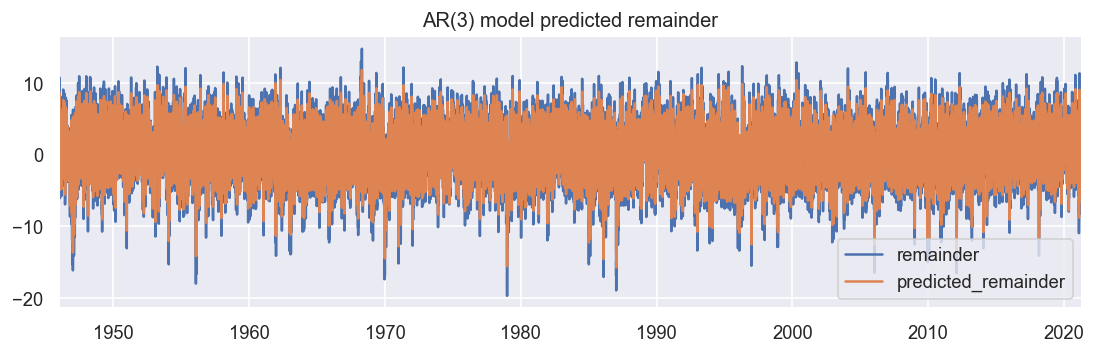

In [108]:
ar_remainder(df=df_post, lag_no= 3)

#### Predict temperature based on three lags

In [109]:
def ar_temperature(df, lag_no, plot=True):
    '''
    AR model 
    y: temperature
    X: lags of the remainder, timestep, month dummies
    Return dataframe with predicted temperature
    '''
    df = create_lags(df, lags=lag_no)
    df.dropna(inplace=True)
    linear_full = LinearRegression()
    X_full, y_full = X_full_y_full(df)
    linear_full.fit(X_full, y_full)
    df["ar_pred"] = linear_full.predict(X_full) # predicted temperature
    df['remainder_full'] = df['temp'] - df['ar_pred']
    if plot:
        df[['temp', 'trend_seasonal', 'ar_pred']].plot()
        df[['remainder', 'remainder_full']].plot()
    return df, linear_full, X_full, y_full
    

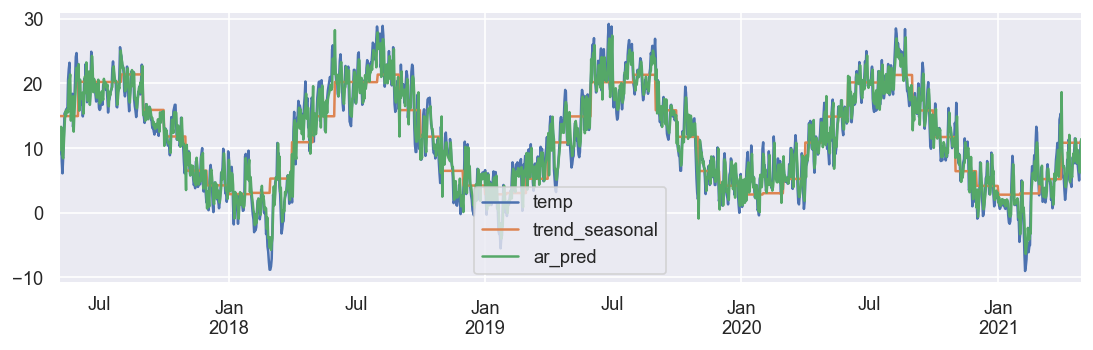

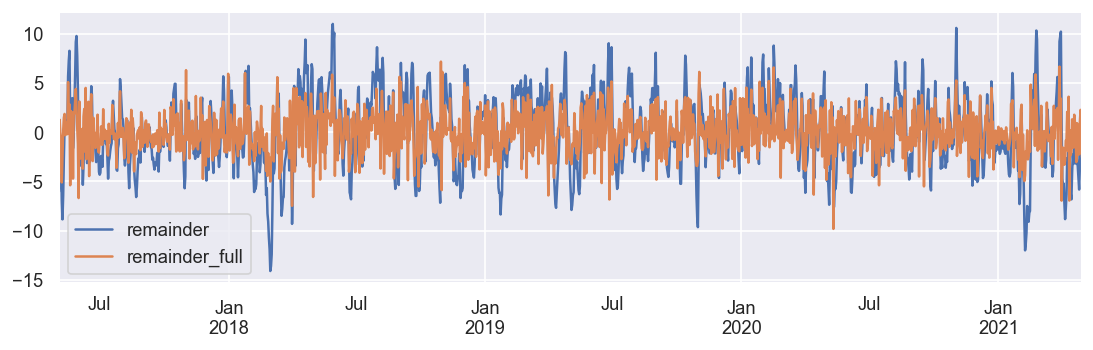

In [110]:
df_five, ar_model_linear, X_full, y_full = ar_temperature(df_five, lag_no=3)

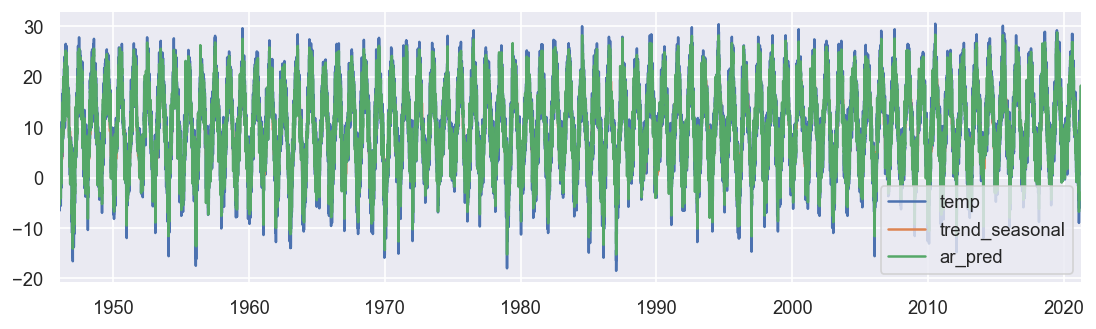

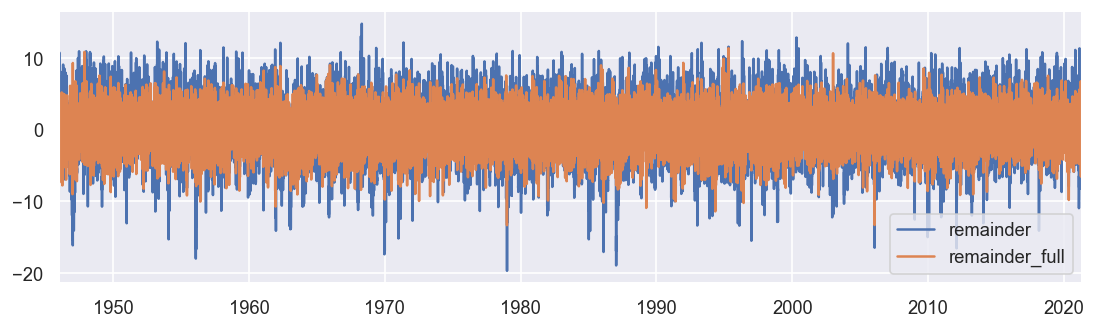

In [111]:
df_post, ar_model_linear_post, X_full_post, y_full_post = ar_temperature(df_post, lag_no=3)

## Autoregressive Integrated Moving Average (ARIMA) model 


$$ y_t = w_0 + \epsilon_t + \sum \limits_{j=1}^{P}w_{j}y_{t-j} + \sum \limits_{i=1}^{Q}\phi_{i}\epsilon_{t-i} $$

* where w_0 is the bias/intercept, the w’s are the coefficients of the autoregressive part of the model, the  phis are the coefficients of the moving average part and the epsilons are some iid noise.

**Components of ARMINA**

    * AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
    * I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
    * MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

**Parameters of the ARIMA:**

- p is the number of autoregressive terms (lags) included in the model, also called the lag order.
- d The number of times that the raw observations are differenced (needed for stationarity), also called the degree of differencing.
- q is the number of lagged forecast errors in the prediction equation. (moving average)

The forecasting equation is constructed as follows.  First, let y denote the dth difference of Y, which means:"

If d=0:  $y_t  =  Y_t$

If d=1:  $y_t  =  Yt - Y_{t-1}$

If d=2:  $y_t  =  (Y_t - Y_{t-1}) - (Y_{t-1} - Y_{t-2})  =  Y_t - 2Y_{t-1} + Y_{t-2}$

In [112]:
df_five.to_csv('data/full_five.csv', index_label=False)

## auto.arima from pmdarima

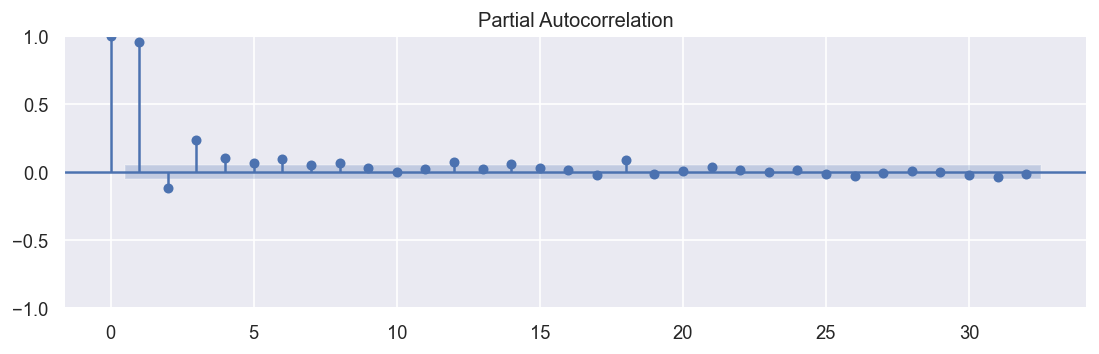

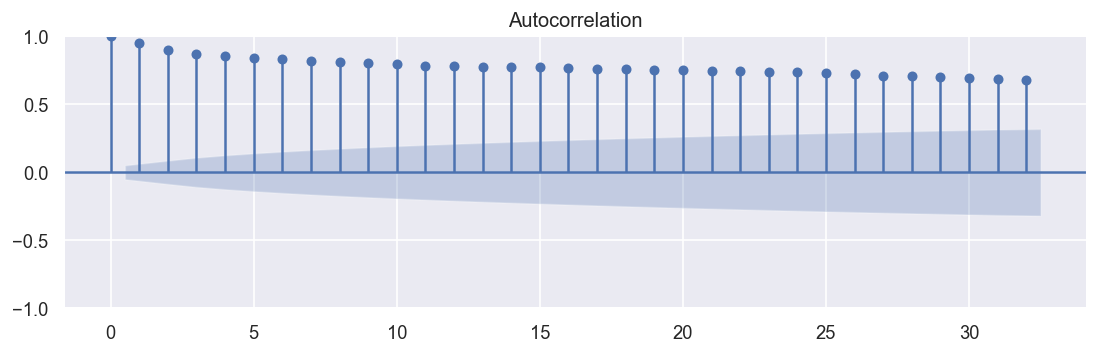

In [113]:
plot_pacf(df_five['temp']);
plot_acf(df_five['temp']);

In [114]:
# y var for arima model
arima_y = df_five[['temp', 'day']]
arima_y.drop('day', axis=1, inplace=True)

In [115]:
# Load the arima_auto model (code in arima_parameters.ipynb)
# The best parameters:  ARIMA(3,1,1)(4,1,0)[12] - : AIC=6602.415
arima_model = pickle.load(open('arima_model.pkl', 'rb'))

In [116]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1458
Model:             SARIMAX(3, 1, 1)x(4, 1, [], 12)   Log Likelihood               -3292.208
Date:                             Thu, 29 Sep 2022   AIC                           6602.415
Time:                                     16:37:25   BIC                           6649.898
Sample:                                          0   HQIC                          6620.137
                                            - 1458                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9575      0.033     29.457      0.000       0.894       1.021
ar.L2         -0.3496      0.036     -9.832      0.000      -0.419      -0.280
ar.L3          0.1207      0.030      4.080      0.000       0.063       0.179
ma.L1         -0.9282      0.018    -51.639      0.000      -0.963      -0.893
ar.S.L12      -0.8042      0.028    -28.883      0.000      -0.859      -0.750
ar.S.L24      -0.5751      0.032    -18.001      0.000      -0.638      -0.513
ar.S.L36      -0.3899      0.031    -12.431      0.000      -0.451      -0.328
ar.S.L48      -0.1777      0.027     -6.668      0.000      -0.230      -0.125
sigma2         5.5334      0.190     29.158      0.000       5.161       5.905
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                10.74
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             0.04
Prob(H) (two-sided):                  0.49   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [117]:
# Fit the model
arima_model.fit(df_five['temp'])

ARIMA(order=(3, 1, 1), scoring_args={}, seasonal_order=(4, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [118]:
arima_model.order

(3, 1, 1)

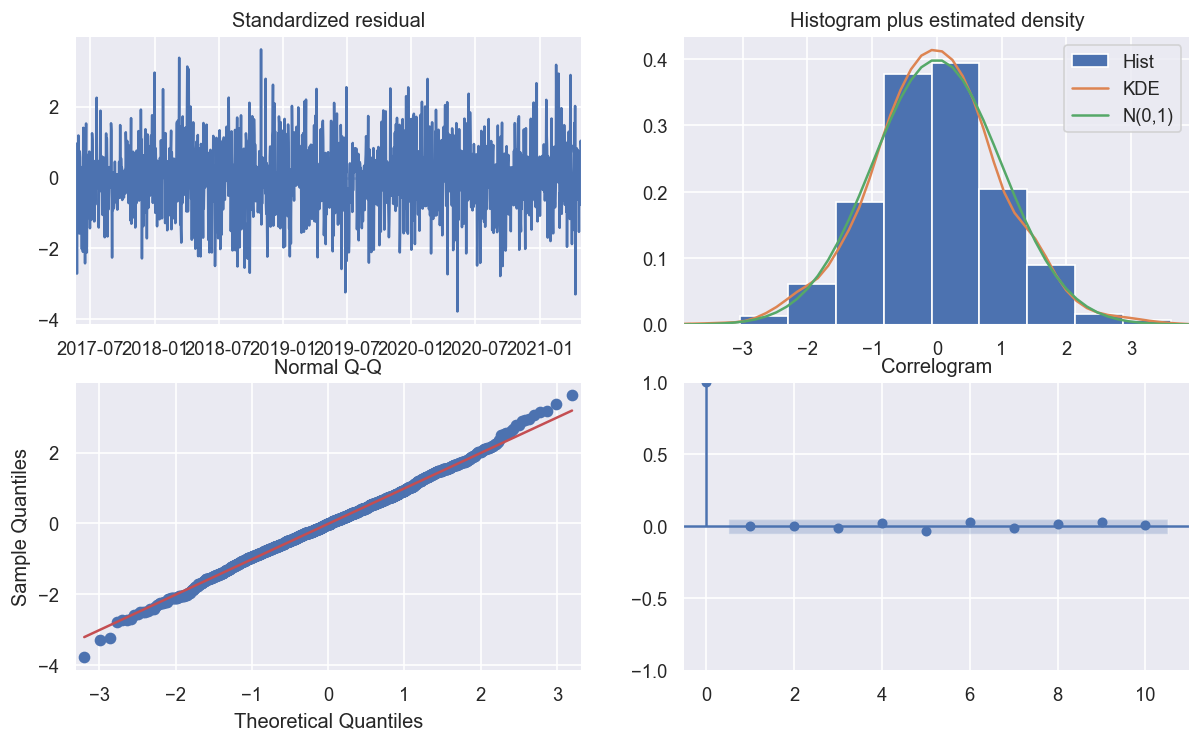

In [119]:
arima_model.plot_diagnostics(figsize=(12,7))
plt.show()

In [120]:
# Predict the temperature for the train sample
# calculate prediction error: difference between predicted and real values divided by real value
arima_pred = arima_model.predict_in_sample(dynamic=False)
df_five['arima_pred'] = arima_pred
df_five['diff_arima'] = abs((df_five['temp'] - arima_pred) / df_five['temp'])

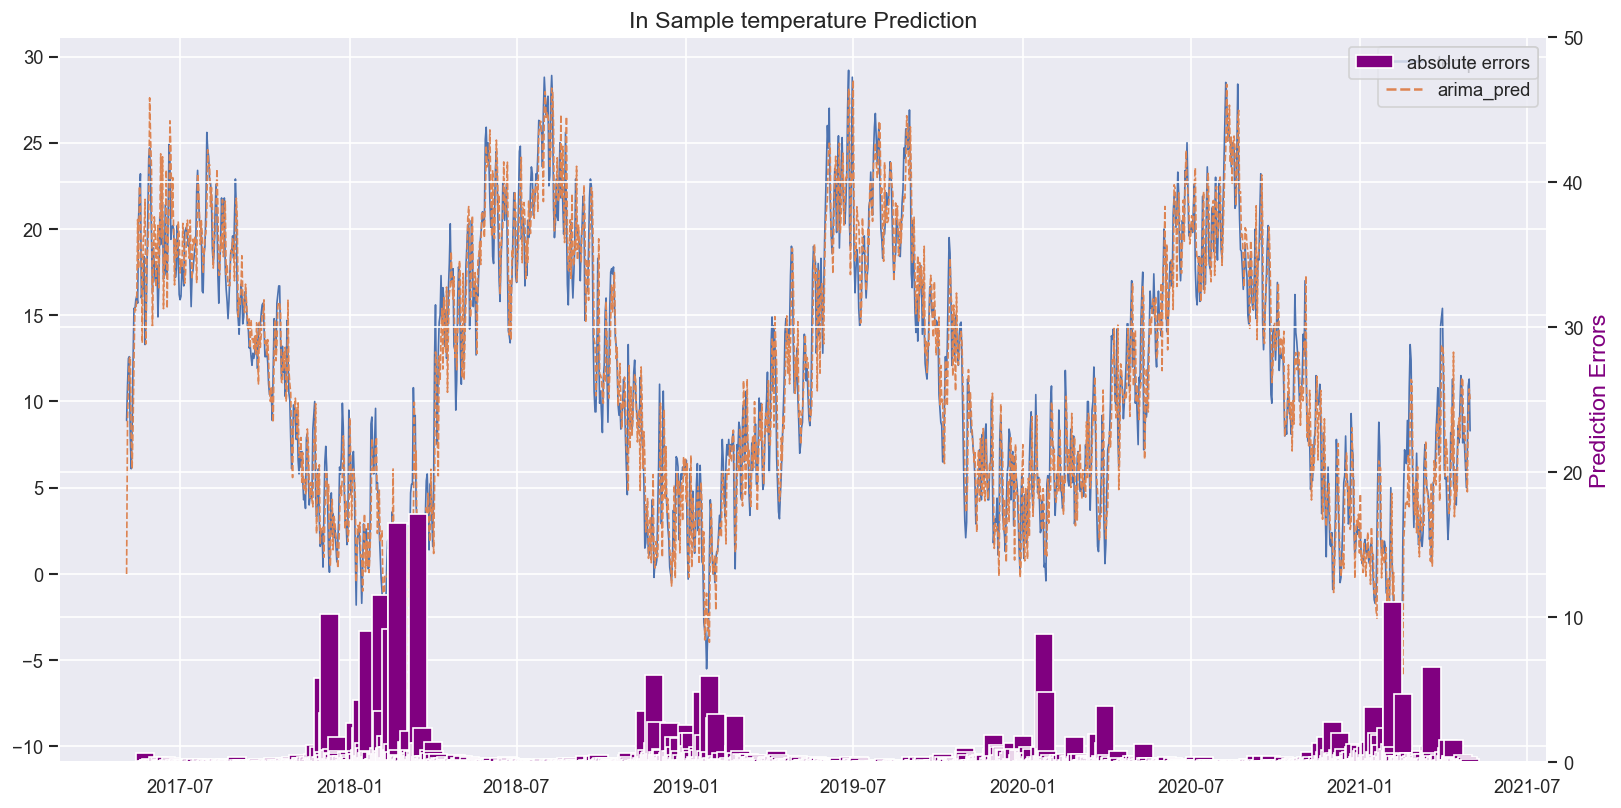

In [121]:
# Plot the real and predicted temperature
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("In Sample temperature Prediction", fontsize=14)
sns.lineplot(data=df_five[['temp', 'arima_pred']], linewidth=1.0)

# Plot the prediction errors on a separate axis (ax2)
ax2 = ax1.twinx() 
ax2.set_ylabel('Prediction Errors', color='purple', fontsize=14)  
ax2.set_ylim([0, 50])
ax2.bar(height=df_five['diff_arima'][20:], x=df_five.index[20:], width=20, color='purple', label='absolute errors')
plt.legend()
plt.show()

### simple AR model with statsmodels

In [122]:
ar_model_simple = AutoReg(endog=df_five['temp'], lags=3).fit()
df_five['prediction_ar_simple']= ar_model_simple.predict()

<AxesSubplot:>

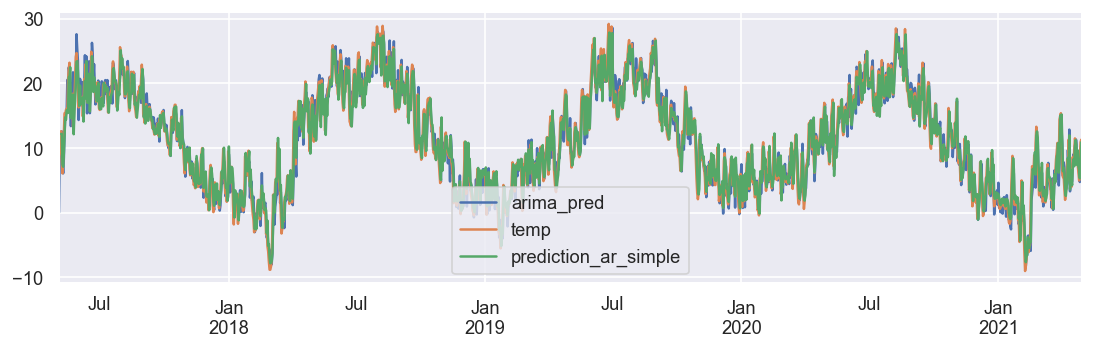

In [123]:
df_five[['arima_pred', 'temp', 'prediction_ar_simple']].plot()

# Evaluate forecasts

## 1. Akaike Information Criterion (AIC) score comparison

$$ AIC = 2 * k - 2 * ln(\hat L) $$

where k is the number of estimated parameters in the model and L_hat is the maximum value of the likelihood function for the model.

* A lower AIC is better
* k penalizes overfitting
* The value of the likelihood function penalizes underfitting


In [124]:
# Arima model - 6602
print(arima_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1458
Model:             SARIMAX(3, 1, 1)x(4, 1, [], 12)   Log Likelihood               -3292.208
Date:                             Thu, 29 Sep 2022   AIC                           6602.415
Time:                                     16:37:47   BIC                           6649.898
Sample:                                 05-04-2017   HQIC                          6620.137
                                      - 04-30-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9575      0.033     29.457      0.000       0.894       1.021
ar.L2         -0.3496      

In [125]:
# Simple autoregressive lag 3 model: 6426
print(ar_model_simple.summary())

                            AutoReg Model Results                             
Dep. Variable:                   temp   No. Observations:                 1458
Model:                     AutoReg(3)   Log Likelihood               -3208.178
Method:               Conditional MLE   S.D. of innovations              2.195
Date:                Thu, 29 Sep 2022   AIC                           6426.355
Time:                        16:37:47   BIC                           6452.769
Sample:                    05-07-2017   HQIC                          6436.210
                         - 04-30-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4399      0.105      4.170      0.000       0.233       0.647
temp.L1        1.0950      0.025     42.941      0.000       1.045       1.145
temp.L2       -0.3680      0.037     -9.899      0.0

## 2.  Cross-validation

* divide training data into subsets (folds)
* in the first iteration, use the first fold to evaluate the second fold
* in the second iteration, use the first and the second fold to evaluate the third fold

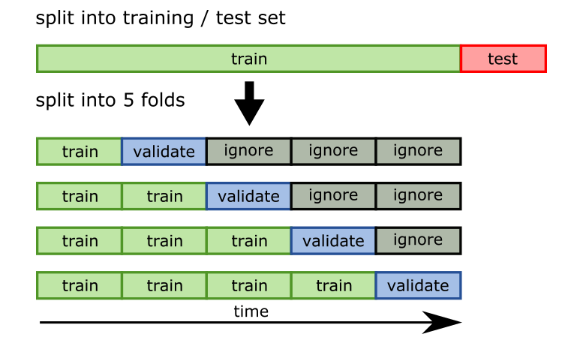

Read: https://otexts.com/fpp2/accuracy.html

In [126]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

### AR(3) model - 5 years

In [127]:
time_series_split = ts_split.split(X_full, y_full)

In [128]:
result = cross_val_score(estimator=ar_model_linear, X=X_full, y=y_full, cv=time_series_split)

In [129]:
result

array([0.79393388, 0.81119068, 0.89993017, 0.90226782, 0.86166105])

In [130]:
round(result.mean(), 3)

0.854

### AR(3) model - 1946-2021

In [131]:
time_series_split_post = ts_split.split(X_full_post, y_full_post)

In [132]:
result_post = cross_val_score(estimator=ar_model_linear_post, X=X_full_post, y=y_full_post, cv=time_series_split_post)

In [133]:
result_post

array([0.91528328, 0.9100042 , 0.90632114, 0.91532124, 0.92038218])

In [134]:
round(result_post.mean(), 3)

0.913

## 3.  Evaluate on test data

In [135]:
df_test = pd.read_csv('data/temp_test.csv', parse_dates = date)

In [136]:
df_test.columns

Index(['Unnamed: 0', 'SOUID', 'DATE', 'TG', 'Q_TG'], dtype='object')

In [137]:
df_test.drop(['Unnamed: 0'], axis=1, inplace=True)

### Transform test data  

In [138]:
df_test= clean_cols(df_test)

In [139]:
df_test= date_to_index(df_test)

In [140]:
df_test = date_cols(df_test)

In [141]:
df_test = missing_to_nan(df_test)

In [142]:
df_test['temp'] = df_test.tg/10

In [143]:
df_test['timestep'] = list(range(len(df_test)))

In [144]:
df_test = seasonal_dum(df_test)

In [145]:
X_test = get_X_months(df_test)

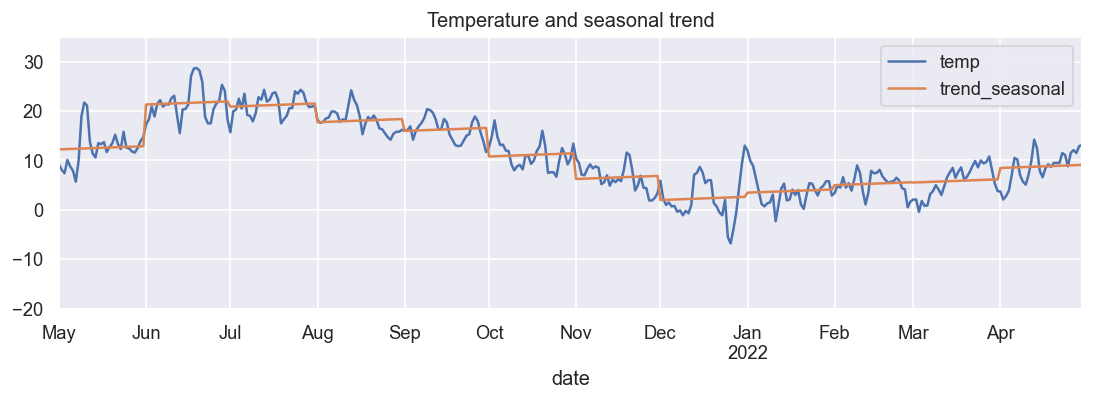

In [146]:
df_test = model_seasonality(df_test, plot=True)

The slope of the trend: [-0.04700429]


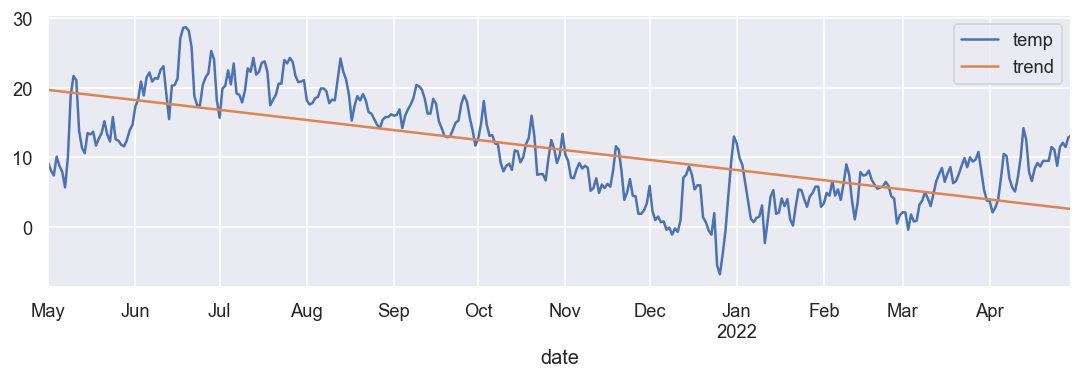

In [147]:
df_test= pred_trend(df_test, plot=True)

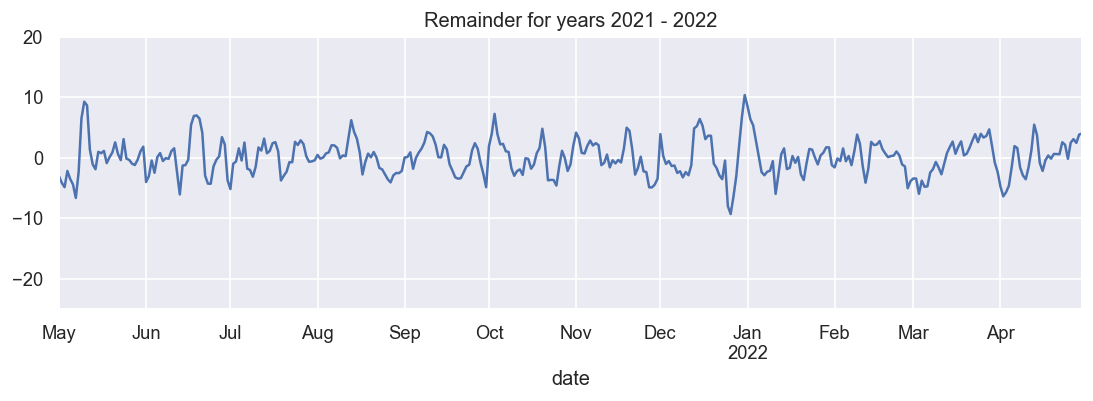

In [148]:
df_test = get_remainder(df_test, plot=True)

### Combine train and test data

In [149]:
df_complete = df_five.append(df_test)

In [150]:
df_complete = create_lags(df=df_complete, lags=3)

In [151]:
df_complete['timestep'] = list(range(len(df_complete)))

In [152]:
df_complete.columns

Index(['souid', 'date', 'tg', 'q_tg', 'year', 'month', 'weekday', 'day',
       'temp', 'timestep', 'trend', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'trend_seasonal', 'remainder', 'predicted_remainder',
       'lag1', 'lag2', 'lag3', 'ar_pred', 'remainder_full', 'arima_pred',
       'diff_arima', 'prediction_ar_simple'],
      dtype='object')

In [153]:
df_complete.drop(['ar_pred', 'remainder_full', 'arima_pred', 'diff_arima', 'predicted_remainder', 'prediction_ar_simple'], axis=1, inplace=True)

In [154]:
df_complete.isna().sum()

souid             0
date              0
tg                0
q_tg              0
year              0
month             0
weekday           0
day               0
temp              0
timestep          0
trend             0
month_2           0
month_3           0
month_4           0
month_5           0
month_6           0
month_7           0
month_8           0
month_9           0
month_10          0
month_11          0
month_12          0
trend_seasonal    0
remainder         0
lag1              1
lag2              2
lag3              3
dtype: int64

In [155]:
df_test = create_lags(df=df_test, lags=3)

In [156]:
# Fill in lags to the end of the test set

# Ensure continuos lags
df_test['lag1'][0] = df_five.temp[-1]

# Second lag (the day before yesterday)
df_test['lag2'][0] = df_five.temp[-2]
df_test['lag2'][1] = df_five.temp[-1]

# Third lag
df_test['lag3'][0] = df_five.temp[-3]
df_test['lag3'][1] = df_five.temp[-2]
df_test['lag3'][2] = df_five.temp[-1]


In [157]:
X_test_full = df_test.drop(['tg', 'temp', 'q_tg', 'month', 'weekday', 'year', 'day', 'date', 'souid', 'trend_seasonal', 'remainder', 'trend'], axis=1)
X_test_full.columns

Index(['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'lag1', 'lag2', 'lag3'],
      dtype='object')

In [164]:
y_test_full = df_test['temp']

In [158]:
len(X_test_full.columns)

15

In [159]:
X_test_full.columns

Index(['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'lag1', 'lag2', 'lag3'],
      dtype='object')

In [161]:
df_test["ar_pred"] = ar_model_linear.predict(X_test_full)

In [165]:
# Test score with model fitted for five year data
ar_model_linear.score(X_test_full, y_test_full)

0.8645785785926541

In [168]:
# Test score with model fitted for 1946-2021 data
ar_model_linear_post.score(X_test_full, y_test_full)

0.7715045358589344

In [166]:
# Train score five year data 
ar_model_linear.score(X_full, y_full)

0.9181468593559187

In [167]:
# Train score 1946-2021
ar_model_linear_post.score(X_full_post, y_full_post)

0.9147513343810934

# Forecast future temperature

### AR(3) forecast

In [169]:
df_complete.dropna(inplace=True)

In [170]:
# Train model with combined dataset
X_comp = df_complete.drop(['tg', 'temp', 'q_tg', 'month', 'weekday', 'year', 'day', 'date', 'souid', 'trend_seasonal', 'remainder', 'trend'], axis=1)
y_comp = df_complete['temp']

linear_comp = LinearRegression()
linear_comp.fit(X_comp, y_comp)

LinearRegression()

In [171]:
X_comp

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3
2017-05-07,3,0,0,0,1,0,0,0,0,0,0,0,-2.453845,-4.053920,-6.053995
2017-05-08,4,0,0,0,1,0,0,0,0,0,0,0,-2.353770,-2.453845,-4.053920
2017-05-09,5,0,0,0,1,0,0,0,0,0,0,0,-6.953695,-2.353770,-2.453845
2017-05-10,6,0,0,0,1,0,0,0,0,0,0,0,-8.853620,-6.953695,-2.353770
2017-05-11,7,0,0,0,1,0,0,0,0,0,0,0,-6.453545,-8.853620,-6.953695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26,1818,0,0,1,0,0,0,0,0,0,0,0,-0.185205,2.136045,2.557295
2022-04-27,1819,0,0,1,0,0,0,0,0,0,0,0,2.493546,-0.185205,2.136045
2022-04-28,1820,0,0,1,0,0,0,0,0,0,0,0,3.072296,2.493546,-0.185205
2022-04-29,1821,0,0,1,0,0,0,0,0,0,0,0,2.451047,3.072296,2.493546


### Create future instance (timestamp, months, timestep, lags)

In [174]:
def create_new_day(df):
    X_future = []
    lags = []
    month = [0]*3 + [1] + [0]*7 # all months except May set to 0, the month_5 set to 1 (4th month in the dataframe)
    for i in range(1,4):
        lags.append(df.remainder[-i])
    
    X_future.append(X['timestep'].max()+1) # increment time step by 1
    X_future.extend(month) # add months
    X_future.extend(lags) 
    X_future = pd.DataFrame([X_future], columns = X_comp.columns)
    day_1= df.index.max() + datetime.timedelta(days=1)
    X_future.rename(index={X_future.index[0]:day_1}, inplace=True)
    
    return X_future

In [175]:
X_day1 = create_new_day(df_complete)

In [176]:
X_day1

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3
2022-05-01,27514,0,0,0,1,0,0,0,0,0,0,0,4.008547,3.829797,2.451047


In [177]:
# Predict temperature for future data point1
y_future = linear_comp.predict(X_day1)

In [178]:
# Temperature forecast for one day in the future - 1st May 2022
y_future

array([11.62470205])

### ARIMA forecast

In [181]:
# predict the next year
future_forecast = arima_model.predict(n_periods=366)

In [183]:
print(future_forecast[-1])

35.0306558774504
